# Iterative Closest Point to find book

In [14]:
import numpy as np
import matplotlib.pyplot as plt 
import trimesh
from typing import List 
#Drake utils
from pydrake.all import (
    Concatenate,
    Parser,
    RigidTransform,
    Simulator,
    MultibodyPlant,
    DiagramBuilder,
    Context
)
from IPython.display import HTML, SVG, display
from pydrake.systems.framework import Diagram
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.utils import ConfigureParser
from pydrake.all import (
    RigidTransform,
    Simulator,
    MultibodyPlant,
    DiagramBuilder,
    Meshcat, 
    DiagramBuilder, 
    Parser, 
    AddMultibodyPlantSceneGraph,
    MeshcatVisualizer,
    Diagram
)

from manipulation.station import AddPointClouds

import pydot
from pydrake.geometry import Meshcat
from manipulation.icp import IterativeClosestPoint
from pydrake.all import Rgba

# Own utils
from hwstation.utils import setup_builder, plot_and_simulate, visualize_diagram
from hwstation.add_objects import get_library_scenario_data

In [15]:
# Start meshcat
try:
    meshcat = Meshcat(7006)
except:
    pass #This error appears if this cell is executed twice (port 7006 is already taken then)
    
# Get string describing scenario
scenario_data = get_library_scenario_data()

#Setting up all drake simulation objects:
builder, plant, scene_graph, station, parser, scenario = setup_builder(meshcat, scenario_data=scenario_data)

#Simulate environment (right now, only the books fall on the table)
diagram, plant_context, simulator = plot_and_simulate(meshcat, builder, plant, station, time_end=1.5)

In [16]:
diagram_context = diagram.CreateDefaultContext()
context = station.CreateDefaultContext()

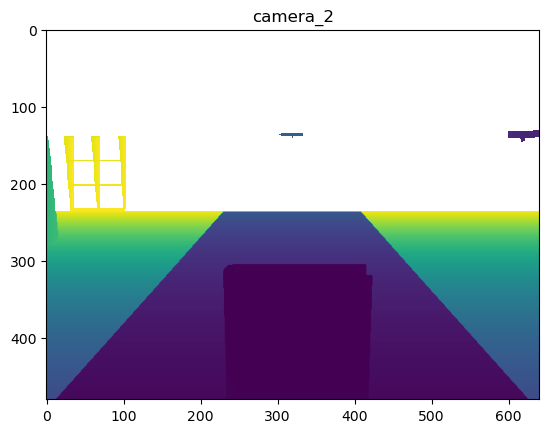

In [17]:

camera_idx = 2
depth_image = station.GetOutputPort(f"table_camera_{camera_idx}.depth_image").Eval(context)
plt.imshow(depth_image.data)
plt.title(f"camera_{camera_idx}")
plt.show()


### Observed point cloud

We need to extract the information from the depth cameras and merge the point clouds.

TODO: need to crop the point clouds. We assume that we know where the table is. Therefore, we 
1. Could crop the point below the table plate (to remove the table plate from the point cloud, we have done that before in an exercise, we could use that). 
2. In addition, we wanna remove cameras (everything outside a reasonable box around the table).

In [18]:
def get_table_pointclouds(diagram_context: Context):
    point_cloud_dict = {}
    for idx in range(4):
        point_cloud_dict[f"table_camera_{idx}_ptcloud"] = diagram.GetOutputPort(f"table_camera_{idx}_ptcloud").Eval(diagram_context)
    return point_cloud_dict

table_pointclouds = get_table_pointclouds(diagram_context)

def merge_point_clouds(table_pointclouds: dict, 
                        downsample_factor: float = 0.005,
                        lower_xyz: List[float] = [0.0, -0.2, 0.5564], 
                        upper_xyz: List[float] = [1.5, 1.5, 0.8]):
    pcd = []
    for key in table_pointclouds.keys():
        cloud = table_pointclouds[key]
        pcd.append(
            cloud.Crop(lower_xyz=lower_xyz, upper_xyz=upper_xyz)
            )
    merged_pcd = Concatenate(pcd)
    down_sampled_pcd = merged_pcd.VoxelizedDownSample(voxel_size=0.005)
    return down_sampled_pcd

def get_merged_pointcloud():
    
    #Get merged point cloud from all cameras:
    table_pointclouds = get_table_pointclouds(diagram_context)
    merged_pcd = merge_point_clouds(table_pointclouds)

    #Ensure that all number are finite:
    merged_pcd_np = merged_pcd.xyzs().transpose()
    mask_points = (merged_pcd_np== np.inf).all(axis=1)
    if mask_points.any():
        sys.exit("No infinite points were expected")
    return merged_pcd

In [19]:
scene_pcl = get_merged_pointcloud()
meshcat.SetObject("merged_cropped_pcl", cloud=scene_pcl, point_size=0.004)

### Get object geometry as point cloud

In [20]:
def convert_obj_to_pc(filename: str, n_samples: int = 10000, show: bool =False) -> np.ndarray:
    book_mesh = trimesh.load(filename)
    book_hull = book_mesh.convex_hull
    sample_points = book_hull.sample(n_samples)
    point_cloud = trimesh.points.PointCloud(sample_points)
    if show:
        scene = trimesh.Scene([mesh, point_cloud])
        scene.show()
    return np.array(point_cloud.vertices).transpose()

book_filename = "hwstation/objects/book.obj"
model_pcl = convert_obj_to_pc(book_filename)


## Set initial guess

In [21]:
height_table = 0.5
initial_guess = RigidTransform(p=[0.0,0.0,height_table])


## Run ICP

In [23]:
X_MS_hat, chat = IterativeClosestPoint(
    p_Om=model_pcl,
    p_Ws=scene_pcl.xyzs(),
    X_Ohat=initial_guess,
    meshcat=meshcat,
    meshcat_scene_path="icp",
    max_iterations=25,
)